In [118]:
import torch
import torch.nn as nn
import numpy as np

In [119]:
from nltk import FreqDist
from nltk.corpus import stopwords

In [120]:


text = """Man and women are the two genders. Strongest man will be awarded as the king and strongest women will be awarded
as the queen. King job is to protect from enemy and queen job is to take care of their people.Enemey used to attack king 
as he is the most strongest person and queen used to protect his king"""
sample_words = text.split()
sample_words = [word for word in sample_words if word not in stopwords.words('english')]
text = " ".join(sample_words)
text = text.replace(',','').replace('.','').lower().split()



In [121]:
text

['man',
 'women',
 'two',
 'genders',
 'strongest',
 'man',
 'awarded',
 'king',
 'strongest',
 'women',
 'awarded',
 'queen',
 'king',
 'job',
 'protect',
 'enemy',
 'queen',
 'job',
 'take',
 'care',
 'peopleenemey',
 'used',
 'attack',
 'king',
 'strongest',
 'person',
 'queen',
 'used',
 'protect',
 'king']

In [122]:
corpus = set(text)
corpus_length = len(corpus)

word_dict = {}
inverse_word_dict = {}

for i, word in enumerate(corpus):
    word_dict[word] = i
    inverse_word_dict[i] = word

data = []

for i in range(2, len(text) - 2):
    sentence = [text[i-2], text[i-1],
               text[i+1], text[i+2]]
    sentence = [ text[i-1],
               text[i+1]]
    target = text[i]
    data.append((sentence, target))
    
print(data[0])

(['women', 'genders'], 'two')


In [123]:
embedding_length = 20

class CBoW(torch.nn.Module):

    def __init__(self, corpus_length, embedding_dim):
        super(CBoW, self).__init__()
        
        self.embeddings = nn.Embedding(corpus_length, embedding_dim)

        self.linear1 = nn.Linear(embedding_dim, 64)
        self.linear2 = nn.Linear(64, corpus_length)
        
        self.activation_function1 = nn.ReLU()
        self.activation_function2 = nn.LogSoftmax(dim = -1)

    def forward(self, inputs):
        embeds = sum(self.embeddings(inputs)).view(1,-1)
        out = self.linear1(embeds)
        out = self.activation_function1(out)
        out = self.linear2(out)
        out = self.activation_function2(out)
        return out

    def get_word_emdedding(self, word):
        word = torch.LongTensor([word_dict[word]])
        return self.embeddings(word).view(1,-1)


In [124]:
model = CBoW(corpus_length, embedding_length)

loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

def make_sentence_vector(sentence, word_dict):
    idxs = [word_dict[w] for w in sentence]
    return torch.tensor(idxs, dtype=torch.long)

print(make_sentence_vector(['women', 'genders'], word_dict))

tensor([6, 2])


In [146]:
log_probs

tensor([[ -0.5209,  -8.4297,  -6.9888,  -5.0172,  -5.6479,  -8.2297,  -8.1652,
          -8.9716,  -7.1169,  -8.1660,  -6.3387, -10.4177,  -9.6779, -10.5033,
          -8.4916,  -8.5945,  -0.9398]], grad_fn=<LogSoftmaxBackward0>)

In [145]:
torch.tensor([word_dict[target]], dtype=torch.long)
#word_dict[target]

tensor([16])

In [126]:
for epoch in range(200):
    epoch_loss = 0
    for sentence, target in data:
        model.zero_grad()
        sentence_vector = make_sentence_vector(sentence, word_dict)  
        log_probs = model(sentence_vector)
        loss = loss_function(log_probs, torch.tensor([word_dict[target]], dtype=torch.long))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.data
    print('Epoch: '+str(epoch)+', Loss: ' + str(epoch_loss.item()))

Epoch: 0, Loss: 76.31633758544922
Epoch: 1, Loss: 71.2906265258789
Epoch: 2, Loss: 66.96836853027344
Epoch: 3, Loss: 63.089595794677734
Epoch: 4, Loss: 59.467872619628906
Epoch: 5, Loss: 56.0507698059082
Epoch: 6, Loss: 52.79047393798828
Epoch: 7, Loss: 49.673553466796875
Epoch: 8, Loss: 46.68126678466797
Epoch: 9, Loss: 43.804508209228516
Epoch: 10, Loss: 41.039527893066406
Epoch: 11, Loss: 38.4152717590332
Epoch: 12, Loss: 35.902835845947266
Epoch: 13, Loss: 33.51782989501953
Epoch: 14, Loss: 31.289813995361328
Epoch: 15, Loss: 29.24917221069336
Epoch: 16, Loss: 27.348907470703125
Epoch: 17, Loss: 25.643957138061523
Epoch: 18, Loss: 24.11220932006836
Epoch: 19, Loss: 22.720956802368164
Epoch: 20, Loss: 21.47917938232422
Epoch: 21, Loss: 20.372804641723633
Epoch: 22, Loss: 19.386329650878906
Epoch: 23, Loss: 18.50359535217285
Epoch: 24, Loss: 17.717132568359375
Epoch: 25, Loss: 17.00832748413086
Epoch: 26, Loss: 16.374645233154297
Epoch: 27, Loss: 15.813638687133789
Epoch: 28, Loss: 1

In [127]:
def get_predicted_result(input, inverse_word_dict):
    index = np.argmax(input)
    return inverse_word_dict[index]

def predict_sentence(sentence):
    sentence_split = sentence.replace('.','').lower().split()
    sentence_vector = make_sentence_vector(sentence_split, word_dict)
    prediction_array = model(sentence_vector).data.numpy()
    print('Preceding Words: {}\n'.format(sentence_split[:2]))
    print('Predicted Word: {}\n'.format(get_predicted_result(prediction_array[0], inverse_word_dict)))
    print('Following Words: {}\n'.format(sentence_split[2:]))

In [128]:
predict_sentence("Strongest man  king")

Preceding Words: ['strongest', 'man']

Predicted Word: awarded

Following Words: ['king']



In [129]:
print(model.get_word_emdedding('king'))

tensor([[-0.0481,  0.2025,  0.0156,  1.0803, -0.3396,  0.6403, -0.4125,  1.9292,
          1.0593, -2.7998, -1.2552,  0.5306, -0.1322, -0.0720,  0.1839, -0.7774,
          1.2836,  1.3239,  0.4051, -0.2077]], grad_fn=<ViewBackward0>)


In [130]:
# Learned W
a,b,c,d,_ = model.parameters()
#print(W.detach())

In [131]:
a

Parameter containing:
tensor([[-2.3207e-01,  2.9727e-01,  9.3533e-01, -4.3204e-01, -1.6656e+00,
          9.2216e-02, -9.3560e-02, -8.6812e-01, -1.7401e-01,  6.5533e-01,
         -2.8164e-01,  9.8210e-01, -1.5182e+00,  1.2059e+00, -8.2326e-01,
         -5.0173e-01, -9.7645e-01,  5.1563e-02,  2.2490e-01, -8.5809e-01],
        [ 1.7711e-01,  5.4548e-01,  5.9204e-01,  2.1921e-01, -8.5741e-01,
          8.6761e-01,  7.5437e-01,  1.4008e+00, -4.6346e-01,  1.9716e+00,
         -1.2992e-01, -2.0052e-01,  1.4731e+00,  1.4667e+00, -9.3849e-02,
          2.7421e-01, -3.0230e+00, -1.9555e+00, -1.8085e+00, -7.3460e-01],
        [ 2.7021e-02, -5.1916e-01, -2.0333e+00,  1.4418e+00, -8.0657e-01,
         -7.4981e-01, -1.8927e+00, -5.3023e-01,  4.0377e-01,  8.6832e-01,
          1.4865e-02,  1.0550e+00, -2.0185e-01,  3.5015e-01,  2.5411e-02,
         -2.9877e-01, -1.0717e+00, -2.0476e-01,  6.0309e-01,  1.6662e+00],
        [-1.4948e+00, -1.2762e+00,  1.0246e+00,  7.6316e-01, -9.5577e-01,
         -8.5

In [132]:
word_list = list(set(text))


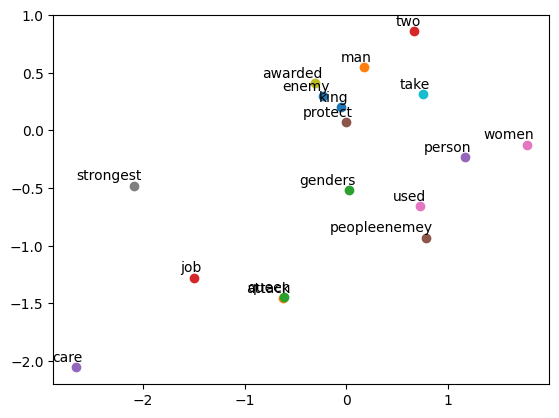

In [133]:
import matplotlib.pyplot as plt
for i, word in enumerate(word_list):
    
    W = a.detach()
    x,y = float(W[i][0]), float(W[i][1])
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
plt.show()